# Anomaly Detection Project for BETH dataset

## By Marco Pasca , mat.2090301

The goal of this project is to design an anomaly detection mechanism in order to do analysis on the BETH cyberseurity dataset. In particular the analysis, as it will be seen, has been done using machine learning methods.

### Introduction to the anomaly detection task

Anomaly detection is the process of identifying unexpected items or events in a dataset which deviate from its normal behavior. This kind of applications are vital to industries to capture malfunctionings and anomalous behaviors which can mutate in losses of any kind (financial, production, etc.).
Anomaly detection use cases can be categorized into three types depending on the type of data that is available for the task.
Supervised learning aims to detect anomalies by using labeled data which represents previous anomalies; unsupervised anomaly detection requires an unlabeled dataset for both training and testing; clean data setting is characterized by a training test composed only by nominal data and a test set filled with some anomalies.
The task of finding the best anomaly detection model for a data set requires multiple steps that include data preparation, parameter optimization, validation, and model selection. Each of these steps could have multiple sub-steps. For example, data preparation could include scaling, dimensionality reduction, and feature engineering.
In this particular analysis three different machine learning methods has been used to satisfy the task: One-class SVM, Isolation Forest and Gaussian Mixture Model. For each of this models, the performances have been evaluated using the area under the receiver operating characteristic (AUROC), and have been visualized with different scatter plots.

### BETH dataset

The BETH dataset currently represents 8,004,918 events
collected over 23 honeypots, running for about five non contiguous hours on a major cloud provider. For benchmarking and discussion, we selected the initial subset of the process logs. This subset was further divided into training, validation, and testing sets with a rough 60/20/20 split based on host, quantity of logs generated, and the activity logged—only the test set includes an attack.
In particular the training set, which contains only normal data contains about 763.144 samples, while validation and test have about 188.967 samples.
About the collection methodlogy The challenge of crafting a honeypot is two-fold: make it tempting enough to infiltrate, and track activity without
being detected. This is typically done making the resources easily accesible to the attacker.
The dataset is composed of two sensor logs: kernel-level process calls and network traffic. For this project only the kernel level process calls has been considered fo the anomaly detection task. To be more specific each process call consist of 14 raw features  and 2 labels.
Each record was manually labelled suspicious (sus) or evil to assist analysis. Logs marked suspicious indicate unusual activity or outliers in the data distribution, such as an external userId with a systemd process, infrequent
daemon process calls, or calls to close processes that we did not observe as being started. Evil indicates a malicious external presence not inherent to the system, such as a bash execution call to list the computer’s memory information, remove other users’ ssh access, or un-tar an added file. Events marked evil are considered “out of distribution,” as they are generated from
a data distribution not seen during training.


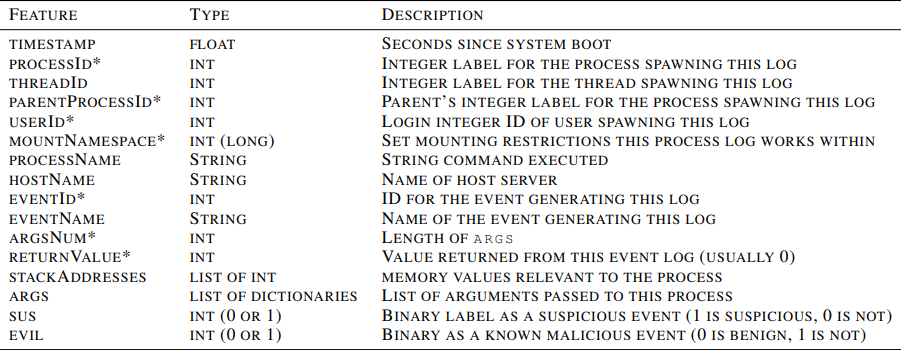


### Importing libraries 

The first step is to import the required libraries. We will use the sklearn libraries for the machine learning methods, and also for the prerocessing of the data, while the matplotlib is used to plot the dataset on 2 dimensions. Pandas and numpy are used to work with the data, since the dataset is treated as a dataframe , to a have better visualiziation options.

In [1]:
from os import path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

## Pre-processing 

### Creation of the dataset class
In this section we will create a BethDataset object which will allow us to load the desired dataset from our local folder, also it will permit us to select a subset of the data if necessary. A relevent operation in this class is the feature selection and the mapping that has been adopted according to the BETH dataset instructions; the dataset has been reduced from 14 to 7 features, which are considered the most relevant to the anomaly detection task, while the label "sus" has been adopted to obtain the classification from anomalous and normal data.
Now let us consider all the raw features and why some of them have been removed or not according to the paper attached to the BETH dataset webpage:

*   timestamp: We left this field out to consider the dataset as a sample from a distribution rather than time series. It can be used depending on the method of anomaly detection choosed;

*   processID: Process IDs 0, 1, and 2 are meaningful since these are always values used by the OS, but otherwise a random number is assigned to the process upon creation. In this case 0 is assigned if processID is in [0,1,2] otherwise it will be 1;

*   threadID: this value did not appear useful in our analysis, it might suggest how to link process calls if obfuscated in the system;

*   parentProcessID: same mapping as processID;

*   userID: The default in Linux systems is to assign OS activity to some number below 1000 (typically 0). As users login, they are assigned IDs starting at 1000, incrementally. This can be altered by a user, but none of the current logs gave evidence an attacker did this. We used a binary variable to indicate userId < 1000 or userId ≥ 1000;

*   mountNamespace: This field is somewhat consistent across our hosts and determines the access a certain process has to various mount points. The most common value for this feature is 4026531840 or 0xF0000000.  It is noted that all logs with userId ≥ 1000 had a mountNamespace of 4026531840, while some OS userId traffic used different mountNamespace values. We converted this feature into a binary mapping for whether or not mountNamespace = 4026531840;

*   processName: This is a string field of variable length (ranging from one to fifteen characters). For our baselines, we refrained from utilising this, although the model should be given an encoding of this using a hash or ability to learn a useful encoding on its own;

*   hostName: This field is useful for grouping the dataset into related subsets of data generated from the same honeypot. It is not useful for this analysis;

*   eventID: Linux systems assign an integer corresponding to the eventName;

*   eventName: Event names uniquely map to eventId, so we drop it from training.

*   argNum: This raw feature is included as-is, since, at this time, adequately parsing args requires either more sophisticated pre-processing;

*   returnValue:  This is also called the exit status and can be used to determine whether a call completed successfully or not. Mappings for this can vary, as this value is decided between the parent and child process. We mapped returnValue into three values based on the common usage of the field: -1 when negative (bad errors), 0 when zero (success), and 1 when positive (success and signalling something to the parent process);

*   stackAddresses: It is difficult to clearly relate this feature, so it was dropped from training;

*   args: There are many options in this variable list of dictionaries. For simplicity, we refrain from utilising any of these values.

The entire class is structured in a pandas dataframe in order to obtain a better management of the single coloumns.

In [2]:
class BethDataset():

    def __init__(self,split=None,subset=0):
        if split=="train":
            df = pd.read_csv("labelled_training_data.csv")
        elif split=="val":
            df = pd.read_csv("labelled_validation_data.csv")

        elif split=="test":
            df = pd.read_csv("labelled_testing_data.csv")

        else:
            print("Error with loading dataset")

        y = pd.DataFrame(df[["evil"]])
        X = pd.DataFrame(df[["processId", "parentProcessId", "userId", "mountNamespace", "eventId", "argsNum", "returnValue"]])

        X["processId"] = X["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
        X["parentProcessId"] = X["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
        X["userId"] = X["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
        X["mountNamespace"] = X["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
        X["eventId"] = X["eventId"]  # Keep eventId values (requires knowing max value)
        X["returnValue"] = X["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))  # Map to success/success with value/error

        # Extract values
        self.X = X
        self.Y = y
        # Subsample data
        if subset > 0:
          self.X, self.Y = self.X[::subset], self.Y[::subset]



    def __len__(self):
            return len(self.y_labels)


    def __getItem__(self,idx):
            return self.X_data[idx],self.y_labels[idx]

In this cell we initialize the training, validation and test sets as BethDataset object, so to access the data points we can use the dataset.X attribute, while for the labels we have the dataset.Y attribute. In the next cell we use the head function of pandas to have an initial visualization of the data (to be more precise the first 5 rows).

In [3]:
train_dataset = BethDataset(split="train",subset=0)
val_dataset = BethDataset(split="val",subset=0)
test_dataset = BethDataset(split="test",subset=0)


In [4]:
df = pd.DataFrame(train_dataset.X)
display(df.head())



,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,1,0,0,1,157,5,0
1,1,0,0,1,3,1,0
2,1,0,0,1,1010,0,0
3,1,1,0,0,21,2,2
4,1,1,0,0,1005,4,0


### Standard scaling and normalization

Standard scaling is necessary to obtain good results with our data since many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In this case we have used the StandardScaler class from the sklearn.preprocessing library which standardizes features by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples and s is their standard deviation.
To be more specifi we first create a StandardScaler object, then we apply the fit method on the training set, which is our reference and then apply the transformation with the tranform method on all our dataset instances.

After this operation an additional normalization is done on the datasets so that all the values are compressed in a range between 0 and 1. This phase has been added to the standard scaling because of the high range of values that we have for each feature, and in order to obtain better performances.

In [5]:

scaler = StandardScaler()
scaler.fit(train_dataset.X[0:])
train_dataset.X[0:] = scaler.transform(train_dataset.X[0:])
val_dataset.X[0:] = scaler.transform(val_dataset.X[0:])
test_dataset.X[0:] = scaler.transform(test_dataset.X[0:])


In [6]:
display(df.head())


,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,0.147817,-2.931344,-0.03615,1.703114,-0.340569,1.736080,-0.637184
1,0.147817,-2.931344,-0.03615,1.703114,-0.740447,-1.246980,-0.637184
2,0.147817,-2.931344,-0.03615,1.703114,1.874340,-1.992744,-0.637184
3,0.147817,0.341140,-0.03615,-0.587160,-0.693708,-0.501215,3.110785
4,0.147817,0.341140,-0.03615,-0.587160,1.861357,0.990315,-0.637184


In [7]:
def normalize(dataset):
    min_val = np.min(dataset)
    max_val = np.max(dataset)
    range_val = max_val - min_val
    normalized = (dataset - min_val) / range_val
    return normalized

In [8]:
train_dataset.X[0:] = normalize(train_dataset.X[0:])
val_dataset.X[0:] = normalize(val_dataset.X[0:])
test_dataset.X[0:] = normalize(test_dataset.X[0:])

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [9]:
display(df.head())

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue
0,1.0,0.0,0.0,1.0,0.152929,1.0,0.0
1,1.0,0.0,0.0,1.0,0.000000,0.2,0.0
2,1.0,0.0,0.0,1.0,1.000000,0.0,0.0
3,1.0,1.0,0.0,0.0,0.017875,0.4,1.0
4,1.0,1.0,0.0,0.0,0.995035,0.8,0.0


### PCA whitening

PCA whitening is techinque with which we try to accomplish principally two things : make the features less correlated with one another and give all the features the same variance. This procedure has been added in the pre-processing part since seems to improve the analysis of the data. By the way PCA whitening is not necessarely beneficial to all the types of data or tasks.
Whitening has two simple steps:

* Project the dataset onto the eigenvectors. This rotates the dataset so that there is no correlation between the components.

* Normalize the the dataset to have a variance of 1 for all components. This is done by simply dividing each component by the square root of its eigenvalue.

In [10]:
pca = PCA(whiten=True).fit(train_dataset.X[0:])
train_dataset.X[0:] = pca.transform(train_dataset.X[0:])
val_dataset.X[0:] = pca.transform(val_dataset.X[0:])
test_dataset.X[0:] = pca.transform(test_dataset.X[0:])

## Data visualization and T-SNE

In order to analyze better our dataset and consequentely to develop an anomaly detection mechanism, we need firstly to have a visualization of the whole dataset, in this case the test dataset, since is the only one which contains data from a real attack, while the training one has only clean samples. Data visualization is obtained using a dimensionality reduction technique thought specifically for this task, such as T-SNE (t-distributed Stochastic Neighbor Embedding).
this is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. Non-linear dimensionality reduction means that the algorithm allows us to separate data that cannot be separated by a straight line. 

The t-SNE algorithm finds the similarity measure between pairs of instances in higher and lower dimensional space. After that, it tries to optimize two similarity measures. It does all of that in three steps. 

* t-SNE models a point being selected as a neighbor of another point in both higher and lower dimensions. It starts by calculating a pairwise similarity between all data points in the high-dimensional space using a Gaussian kernel. The points that are far apart have a lower probability of being picked than the points that are close together. 
* Then, the algorithm tries to map higher dimensional data points onto lower dimensional space while preserving the pairwise similarities. 
* It is achieved by minimizing the divergence between the probability distribution of the original high-dimensional and lower-dimensional. The algorithm uses gradient descent to minimize the divergence. The lower-dimensional embedding is optimized to a stable state.

Respect to other dimensionality reduction techniques, like PCA, T-SNE has been choosen since is more capable to preserve the relationships between data points in lower dimensional space, instead of the variance in the data.

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


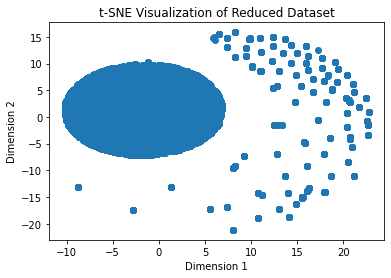

In [11]:


tsne = TSNE(n_components=2, random_state=42)
X_test = tsne.fit_transform(test_dataset.X)


plt.scatter(X_test[:, 0], X_test[:, 1])
plt.title("t-SNE Visualization of Reduced Dataset")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [12]:
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = test_dataset.Y

## One-class SVM

The first machine learning method that has been taken into account is One-class SVM. To be more specific we have not used the classic version of the algorithm since kernelised SVMs scale with O(N^2), instead we have used the scikit-learn’s linear SVM with stochastic gradient descent which is way more faster to converge. Differently from the classic SVM we have only one class, which divides the data between normal and outliers.
Firstly we have applied the fit method to the SGDOneClassSVM object with the training set as parameter , then the predictions has been computed and compared to the original labels, since SVM is a supervised learning algorithm.
To perform a fisrt evaluation of the performance we have choosen the classification_report form sklearn.metris library, which compares the recall and precision values for the 0 and 1 labels. Let us just remember that the precision is the number of true positives ( the number of items correctly labelled as belonging to the positive class) divided by the total number of elements labelled as belonging to the positive class, while the recall value is the number of true positives divided by the total number of elements that actually belong to the positive class. 
In this case we have a precision value of about 0.58 for the label 0 and of 0.87 for the 1 class, while we have a recall value of about 0.27 for the 0 label and 0.91 for the 1 class. 
The principal evaluation method is still the AUROC curve,with the FPR value on the x axis and the TPR value on the y axis, which is, for this model, about 0.61, so not very high, especially if compared with other models as we will see.

In [13]:
np.random.seed(42)

# Perform One-Class SVM anomaly detection
svm_model = linear_model.SGDOneClassSVM(random_state=42)  
svm_model.fit(train_dataset.X[0:])
y_pred = svm_model.predict(test_dataset.X[0:])
y_pred = [0 if i==1 else 1 for i in y_pred]
print(classification_report(test_dataset.Y[0:], y_pred))

              precision    recall  f1-score   support

           0       0.58      0.27      0.37     30535
           1       0.87      0.96      0.91    158432

    accuracy                           0.85    188967
   macro avg       0.72      0.62      0.64    188967
weighted avg       0.82      0.85      0.83    188967



Area under the ROC curve : 0.616630


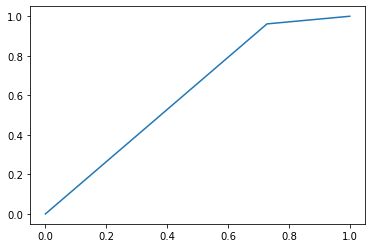

In [14]:
fpr, tpr, thresholds = roc_curve(test_dataset.Y[0:], y_pred)
roc_auc = auc(fpr, tpr) # this generates ValueError[1]
print("Area under the ROC curve : %f" % roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

As we can see from the following plots, we have the reduced dataset with the anomalies highlighted in purple, while the normal data are in the red colour. In particular on the left side there are the original anomalies while on the right one we have the predicted labels. The results appear to be consistent with the performance examinated before since there many visible non recognised anomalies in the predictions. The visualization is done adding the prediction and label coloumns to the reduced dataframe and then using a "rainbow" colour map.

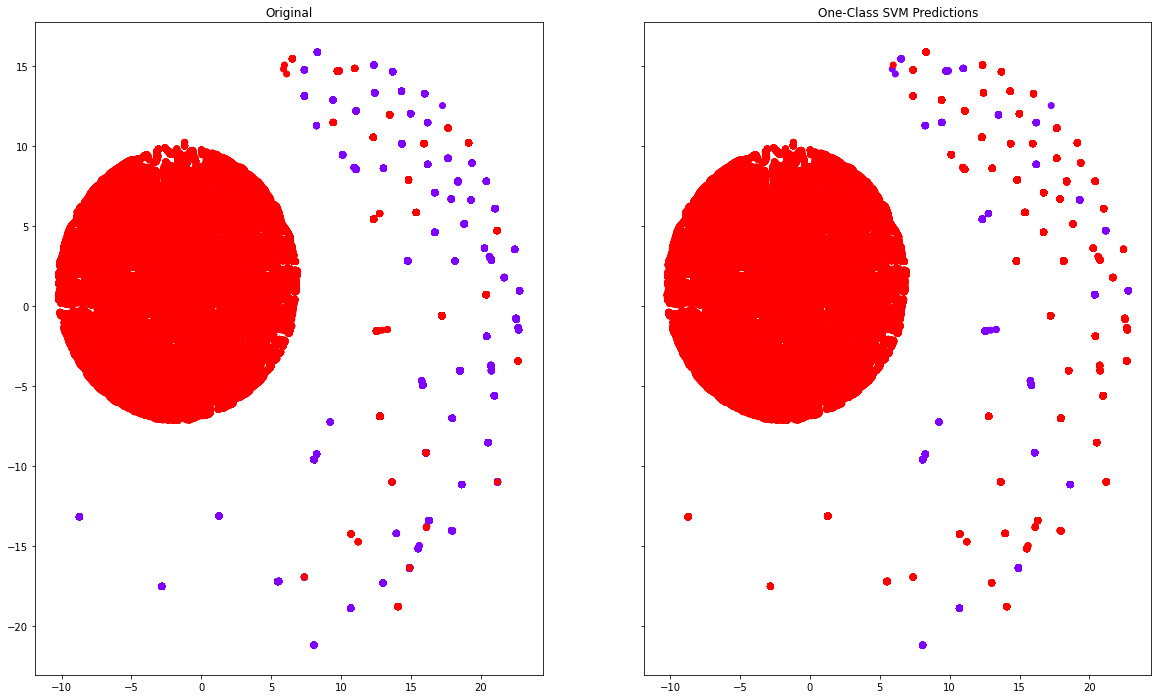

In [21]:
# Visualize the actual and predicted anomalies
df_test['one_class_svm_prediction'] = y_pred

fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(20,12))

# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')

# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')

## Isolation Forest

The second method analyzed in this report is the Isolation Forest algorithm by Fei Tony Liu. This algorithm is based on binary trees to detect anomalies and is recognised as one of the most efficients between the machine learning methods for anomaly detection for its linear time complexity and its low memory requirements.
The premise of the Isolation Forest algorithm is that anomalous data points are easier to separate from the rest of the sample. In order to isolate a data point, the algorithm recursively generates partitions on the sample by randomly selecting an attribute and then randomly selecting a split value between the minimum and maximum values allowed for that attribute. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.
In this specific implementation the level of contamination of the IsolationForest object has been tested with different values until the last one has proved to be the best for the performances, which is 5%. Also the classification_report results are quite good,especially if compared with the one-class svm. In particular we have a precision value of 0.67 for the 0 class and 0.97 for the 1 class, while for the recall value we have about 0.84 for the 0 label and 0.92 for the 1 label. In general the model is capable to classify quite well the outliers as we can see from an AUROC curve value of 0.88 despite the not very good capacity of the algorithm to work with high-dimensional datasets.

In [22]:
ilf = IsolationForest(max_features=7,contamination=0.05)
ilf.fit(train_dataset.X[0:])
y_pred_2 = ilf.predict(test_dataset.X[0:])
y_pred_2 = [0 if i==1 else 1 for i in y_pred_2]
print(classification_report(test_dataset.Y[0:], y_pred_2))

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.67      0.84      0.75     30535
           1       0.97      0.92      0.94    158432

    accuracy                           0.91    188967
   macro avg       0.82      0.88      0.84    188967
weighted avg       0.92      0.91      0.91    188967



Area under the ROC curve : 0.881291


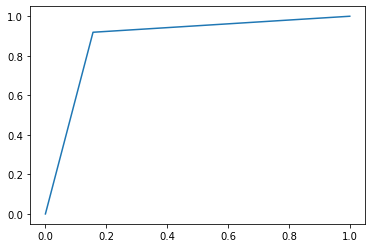

In [23]:
fpr, tpr, thresholds = roc_curve(test_dataset.Y[0:], y_pred_2)
roc_auc = auc(fpr, tpr) # this generates ValueError[1]
print("Area under the ROC curve : %f" % roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

The plots show quite well the good work done by the Isolation Forest algorithm since only few predictions differs from the original ones. By the way there are still some false positives, specially in the very low and very high zone of the graph.

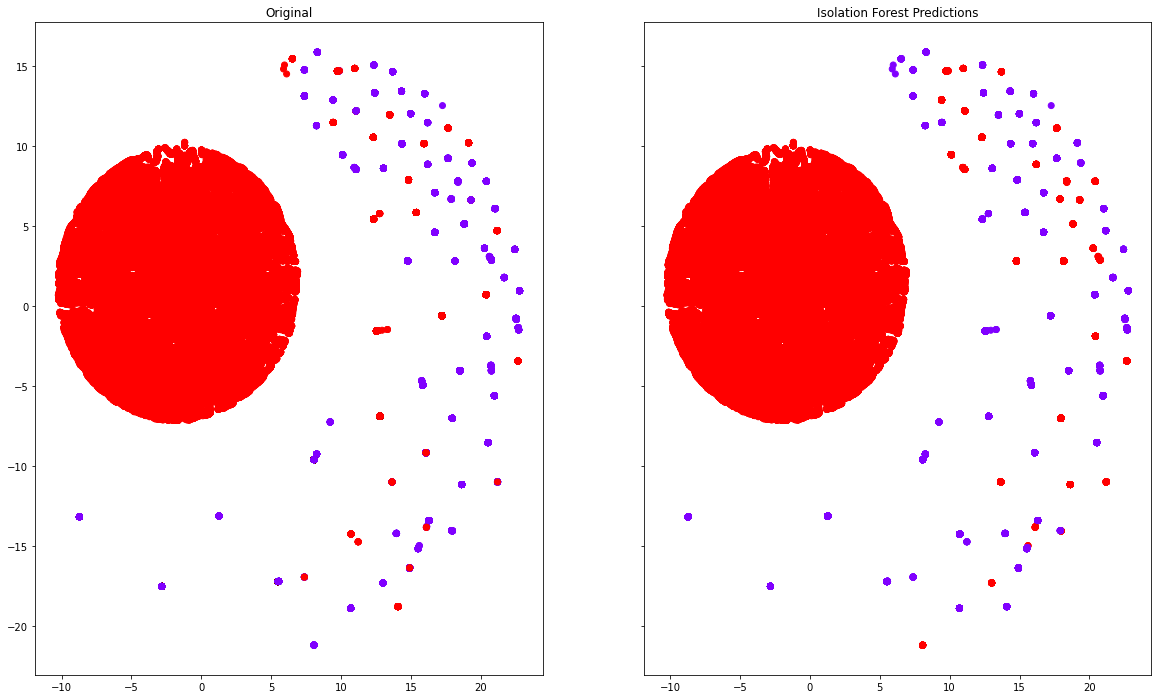

In [25]:
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = test_dataset.Y
df_test['ilf_prediction'] = y_pred_2

# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(20,12))

# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')

# One-Class SVM Predictions
ax1.set_title('Isolation Forest Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['ilf_prediction'], cmap='rainbow')

## Gaussian mixture models

Unlike the first two methods we have discussed the Gaussian mixture model is a clustering method that in this case has been adopted to obtain an anomaly detection task. The Gaussian mixture model (GMM) is a probabilistic model that assumes the data points come from a limited set of Gaussian distributions with uncertain variables. The mean and covariance matrix characterizes each individual Gaussian distribution.
As an extension of the k-means clustering technique, a GMM takes into account the data’s covariance structure and the likelihood of each point being derived from each Gaussian distribution.
It detects outliers by identifying the data points in low-density regions and is trained, since it is an unsupervised learning algorithm, directly on the dataset which contains anomalies, so the test set. Then based on the the log-likelihood of each sample obtained with the score_samples method, a treshold has been setted for anomaly detection , based on a percentage of outliers of about 6%. Finally, a column in the pandas dataframe is created based on the threshold. The data point is predicted to be an outlier if the score is greater than the threshold.
In this case the model seems to obtain slightly better results than the one-class svm, with an AUROC curve value of 0.64, while it is still inferior to the Isolation Forest algorithm's performances.

In [36]:


gmm = GaussianMixture(n_components=3, n_init=5, random_state=42)

# Fit and predict on the data
y_gmm = gmm.fit_predict(test_dataset.X[0:])

score = gmm.score_samples(test_dataset.X[0:])

In [37]:


# Save score as a column
df_test['score'] = score

# Get the score threshold for anomaly
pct_threshold = np.percentile(score, 6)

# Print the score threshold
print(f'The threshold of the score is {pct_threshold:.2f}')

# Label the anomalies
df_test['anomaly_gmm_pct'] = df_test['score'].apply(lambda x: 1 if x > pct_threshold else 0)

The threshold of the score is -3.01


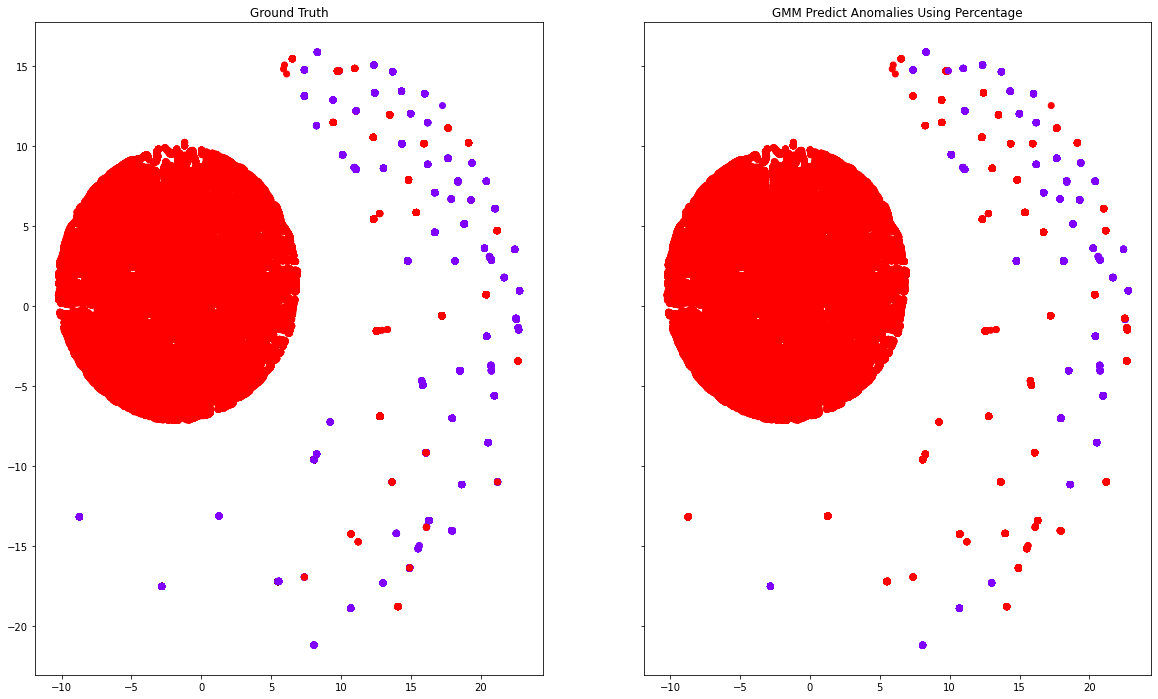

In [38]:
# Visualize the actual and predicted anomalies
fig, (ax0, ax1)=plt.subplots(1,2, sharey=True, figsize=(20,12))
# Ground truth
ax0.set_title('Ground Truth')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')
# GMM Predictions
ax1.set_title('GMM Predict Anomalies Using Percentage')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['anomaly_gmm_pct'], cmap='rainbow')

In [40]:
y_pred_3 = df_test['anomaly_gmm_pct']
print(classification_report(test_dataset.Y,y_pred_3))

              precision    recall  f1-score   support

           0       0.97      0.36      0.52     30535
           1       0.89      1.00      0.94    158432

    accuracy                           0.89    188967
   macro avg       0.93      0.68      0.73    188967
weighted avg       0.90      0.89      0.87    188967



Area under the ROC curve : 0.678426


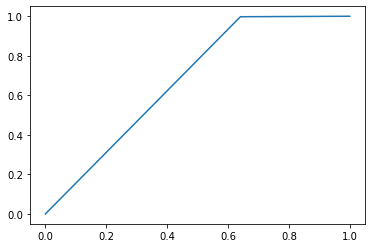

In [41]:
fpr, tpr, thresholds = roc_curve(test_dataset.Y[0:], y_pred_3)
roc_auc = auc(fpr, tpr) # this generates ValueError[1]
print("Area under the ROC curve : %f" % roc_auc)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)

## Conclusions

The goal of this project was initially to design an anomaly detection mechanism based on machine learnig techinques, so after these three implementations we can sum up some conclusions:
* All the methods are quite efficient computationally and in terms of memory and that is why they have been choosen respect to other ones, such as local density based methods like Local Outlier Facor and DBSCAN clustering;
* The Isolation Forest algorithm has proved to be the one with the better performances, 0.88 AUROC curve value, with a quite large margine respect to the other two methods, and good F1-score performances. So apparently for this dataset, an algorithm based on a binary tree has resulted to be more efficient respect to probabilistic clustering and an SGD based SVM. Of course these results may differ with other datasets;
* Only the kernel processes part of the dataset has been used for simplicity and computationally reasons;
* During the selection and testing phase of the machine learning methods to add to this project, algorithms like Local Outlier Factor and KK neighorbs has resulted to be even less accurate than the one-class SVM, other than more computationally expansive with AUROC performances about 0.55/0.58.

### Notes
The initial part of the notebook takes informations from the original paper by Kate Highnam, Kai Arulkumaran, Zachary Hanif, Nicholas R. Jennings  from kaggle.com. Also the results on this project are producted with the label of BETH dataset setted as "evil" and not "sus" such as it is on the paper.